In [153]:
import os
import re
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from MLPClassifierWithSolverLBFGS import MLPClassifierLBFGS

from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

In [154]:
x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')

x_test_df  = pd.read_csv('data/data_reviews/x_test.csv')

tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

y_tr = y_train_df['is_positive_sentiment'].values.tolist()

train_len = len(tr_text_list)
test_len = len(te_text_list)

#for text in tr_text_list:
#    print(text)

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = tr_text_list
X = vectorizer.fit_transform(corpus)
vocal = vectorizer.vocabulary_

In [156]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
def tokenizer(text):
    text = ''.join(i for i in text if not i.isdigit())
    text = re.sub('<[^>]*>','',text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:</span>|<spanclass="es0">|D|P)',text.lower())
    text=re.sub('[\W]+',' ',text.lower())+' '.join(emoticons).replace('-','')
    tokenized= [w for w in text.split() if w not in stop]
    return tokenized

In [157]:
def filter_word(corpus):
    tmp = corpus.copy()
    for i in range(0,len(corpus)):
        tmp[i] = tokenizer(corpus[i])
    return tmp

def count_word(vocal, corpus):
    des = vocal
    for key in des:
        des[key] = 0
    for sentence in corpus:
         for word in sentence:
            if word in des:
                des[word] += 1
    return des

In [158]:
filter_corpus = filter_word(corpus)
filter_V = count_word(vocal, filter_corpus)
#ls = sorted(V1.items(), key=lambda d: d[1],reverse=True)
V = {k:v for k,v in filter_V.items() if v > 1}

check_keys = list(V.keys())
feature_size = len(check_keys)
print(feature_size)

1795


In [159]:
def feature_construct(raw_x):
    tmp = raw_x.copy()
    res = np.zeros((len(raw_x),feature_size), dtype=np.double)
    for i in range(0,len(raw_x)):
        tmp = tokenizer(raw_x[i])
        for j in range(0,feature_size):
            if check_keys[j] in tmp:
                res[i][j] +=1
            
    return res

In [160]:
x_tr = feature_construct(tr_text_list)
x_te  = feature_construct(te_text_list)

print(x_tr.shape)
print(x_te.shape)

(2400, 1795)
(600, 1795)


### Generate a logistic regression model

use k-fold (k>3) for validation

Choose at least one hyperparameter that controls model __complexity and/or its tendency to overfit__. Vary that hyperparameter in a systematic way, testing it using a __cross-validation__ methodology.

Explain the hyperparameter(s) you chose, the range of values you explored (and why), and describe the cross-validation testing in a clear enough manner that the reader could reproduce its basic form, if desired.

Produce at least one figure that shows, for at least one tested hyperparameter, at performance on at least 5 distinct values.<br>
this performance should be plotted __in terms of average error for both training and validation data across the multiple folds__, for each of the values of the hyperparameter. Include information, either in the figure, or along with it in the report, on the uncertainty in these results.

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

tr_loss_list = list()
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(x_tr, y_tr)
    train_proba = lr.predict_proba(x_tr)
    tr_loss_list.append(log_loss(y_tr, train_proba))

idx_min = tr_loss_list.index(min(tr_loss_list))
Best_C =  C_grid[idx_min]

Best C-value for LR : 1000000.000
Train set log-loss at best C-value: 0.0177


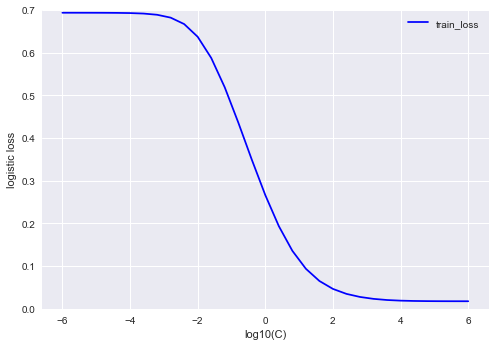

In [162]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Cross-Validation: K-Fold for Basic Count
__choose the best hyperparameter and then predict the result__<br>
in this validation, choose k=10

In [163]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10,random_state=1)
scores_lr = []
X = x_tr
y = np.array(y_tr)
k = 0
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LogisticRegression(C=Best_C,solver='liblinear')
    lr.fit(X_train,y_train)
    scores_lr.append(lr.score(X_test,y_test))
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k, np.bincount(y_train), lr.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_lr), np.std(scores_lr)))

Fold: 1, Class dist.: [1080 1080], Acc: 0.746
Fold: 2, Class dist.: [1080 1080], Acc: 0.746
Fold: 3, Class dist.: [1080 1080], Acc: 0.692
Fold: 4, Class dist.: [1080 1080], Acc: 0.721
Fold: 5, Class dist.: [1080 1080], Acc: 0.700
Fold: 6, Class dist.: [1080 1080], Acc: 0.704
Fold: 7, Class dist.: [1080 1080], Acc: 0.733
Fold: 8, Class dist.: [1080 1080], Acc: 0.667
Fold: 9, Class dist.: [1080 1080], Acc: 0.683
Fold: 10, Class dist.: [1080 1080], Acc: 0.667

Cross-Validation accuracy: 0.706 +/- 0.028


### Use TF-IDF

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
X_all = tr_text_list + te_text_list # Combine both to fit the TFIDF vectorization.
tfidf_vec.fit(X_all)
X_all = tfidf_vec.transform(X_all)

X_tf_train = X_all[:train_len] # Separate back into training and test sets. 
X_tf_test = X_all[train_len:]

print(X_tf_train.shape)
print(X_tf_test.shape)
#for i in range(0,len(sent_tf_vec)):

(2400, 5155)
(600, 5155)


In [165]:
tr_loss_list = list()
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(X_tf_train, y_tr)
    train_proba = lr.predict_proba(X_tf_train)
    tr_loss_list.append(log_loss(y_tr, train_proba))

idx_min = tr_loss_list.index(min(tr_loss_list))
Best_tf_C =  C_grid[idx_min]

Best C-value for LR : 1000000.000
Train set log-loss at best C-value: 0.0000


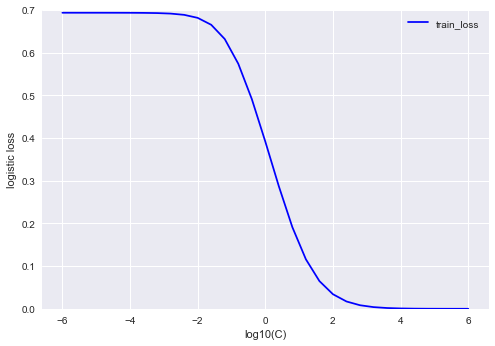

In [166]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Cross-Validation: K-Fold for TF-IDF
__choose the best hyperparameter and then predict the result__<br>
in this validation, choose k=10

In [167]:
folds = StratifiedKFold(n_splits=10,random_state=1)
scores_tf_lr = []
X = X_tf_train
y = np.array(y_tr)
k = 0
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LogisticRegression(C=Best_tf_C,solver='liblinear')
    lr.fit(X_train,y_train)
    scores_lr.append(lr.score(X_test,y_test))
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k, np.bincount(y_train), lr.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_lr), np.std(scores_lr)))

Fold: 1, Class dist.: [1080 1080], Acc: 0.829
Fold: 2, Class dist.: [1080 1080], Acc: 0.817
Fold: 3, Class dist.: [1080 1080], Acc: 0.771
Fold: 4, Class dist.: [1080 1080], Acc: 0.800
Fold: 5, Class dist.: [1080 1080], Acc: 0.762
Fold: 6, Class dist.: [1080 1080], Acc: 0.779
Fold: 7, Class dist.: [1080 1080], Acc: 0.771
Fold: 8, Class dist.: [1080 1080], Acc: 0.783
Fold: 9, Class dist.: [1080 1080], Acc: 0.800
Fold: 10, Class dist.: [1080 1080], Acc: 0.808

Cross-Validation accuracy: 0.749 +/- 0.050


### Generate a neural network (or MLP) model with Basic Count

In [168]:
def MLP_runs(state):
    start_time_sec = time.time()
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=state,)
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_lbfgs.fit(x_tr, y_tr)
        elapsed_time_sec = time.time() - start_time_sec
        print('finished LBFGS run %2d/%d after %6.1f sec | %3d iters | %s | loss %.3f' % (
            state, n_runs, elapsed_time_sec,len(mlp_lbfgs.loss_curve_),
            'converged   ' if mlp_lbfgs.did_converge else 'NOT converged',
            mlp_lbfgs.loss_))
    return mlp_lbfgs

In [169]:
n_runs = 16
result_relu = []
for i in range(0, n_runs):
        result_relu.append(MLP_runs(i))

finished LBFGS run  0/16 after    0.2 sec |   4 iters | converged    | loss 0.510
finished LBFGS run  1/16 after    1.9 sec | 118 iters | converged    | loss 0.082
finished LBFGS run  2/16 after    2.5 sec | 173 iters | NOT converged | loss 0.018
finished LBFGS run  3/16 after    2.6 sec | 176 iters | NOT converged | loss 0.018
finished LBFGS run  4/16 after    2.6 sec | 175 iters | NOT converged | loss 0.019
finished LBFGS run  5/16 after    0.1 sec |   5 iters | converged    | loss 0.693
finished LBFGS run  6/16 after    2.6 sec | 180 iters | NOT converged | loss 0.018
finished LBFGS run  7/16 after    1.3 sec |  76 iters | converged    | loss 0.103
finished LBFGS run  8/16 after    2.5 sec | 158 iters | NOT converged | loss 0.042
finished LBFGS run  9/16 after    2.5 sec | 178 iters | NOT converged | loss 0.020
finished LBFGS run 10/16 after    2.6 sec | 177 iters | NOT converged | loss 0.026
finished LBFGS run 11/16 after    2.7 sec | 169 iters | NOT converged | loss 0.024
finished

As the result Shown, the best one is __relu with state = 1 ( converged, loss = 0.082 )__ 

__result_relu[1]__<br>
MLPClassifierLBFGS(activation='relu', alpha=0.0001, hidden_layer_sizes=[2],
                   max_iter=200, random_state=1, tol=1e-06)

### Cross-Validation: K-Fold with Basic Count
__choose the best hyperparameter and then predict the result__<br>in this validation, choose k=10

In [170]:
folds = StratifiedKFold(n_splits=10,random_state=1)
X = x_tr
y = np.array(y_tr)
k = 0
scores_mlp = []
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=1,)
    mlp_lbfgs.fit(X_train,y_train)
    scores_mlp.append(mlp_lbfgs.score(X_test,y_test))
    print('Fold: %s, Acc: %.3f' % (k, mlp_lbfgs.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_mlp), np.std(scores_mlp)))

Fold: 1, Acc: 0.779
Fold: 2, Acc: 0.800
Fold: 3, Acc: 0.792
Fold: 4, Acc: 0.762
Fold: 5, Acc: 0.771
Fold: 6, Acc: 0.742
Fold: 7, Acc: 0.746
Fold: 8, Acc: 0.746
Fold: 9, Acc: 0.725
Fold: 10, Acc: 0.750

Cross-Validation accuracy: 0.761 +/- 0.023


### Cross-Validation: K-Fold with TF-IDF
__choose the best hyperparameter and then predict the result__<br>in this validation, choose k=10

In [171]:
def MLP_runs(state):
    start_time_sec = time.time()
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=state,)
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_lbfgs.fit( X_tf_train, y_tr)
        elapsed_time_sec = time.time() - start_time_sec
        print('finished LBFGS run %2d/%d after %6.1f sec | %3d iters | %s | loss %.3f' % (
            state, n_runs, elapsed_time_sec,len(mlp_lbfgs.loss_curve_),
            'converged   ' if mlp_lbfgs.did_converge else 'NOT converged',
            mlp_lbfgs.loss_))
    return mlp_lbfgs

In [172]:
n_runs = 16
result_relu = []
for i in range(0, n_runs):
        result_relu.append(MLP_runs(i))

finished LBFGS run  0/16 after    0.6 sec | 134 iters | converged    | loss 0.000
finished LBFGS run  1/16 after    0.4 sec |  68 iters | converged    | loss 0.011
finished LBFGS run  2/16 after    0.8 sec | 140 iters | converged    | loss 0.000
finished LBFGS run  3/16 after    0.2 sec |  41 iters | converged    | loss 0.087
finished LBFGS run  4/16 after    0.5 sec |  95 iters | converged    | loss 0.000
finished LBFGS run  5/16 after    0.3 sec |  48 iters | converged    | loss 0.015
finished LBFGS run  6/16 after    0.1 sec |   5 iters | converged    | loss 0.693
finished LBFGS run  7/16 after    0.4 sec |  70 iters | converged    | loss 0.041
finished LBFGS run  8/16 after    0.1 sec |   5 iters | converged    | loss 0.693
finished LBFGS run  9/16 after    0.0 sec |   5 iters | converged    | loss 0.693
finished LBFGS run 10/16 after    0.9 sec | 171 iters | NOT converged | loss 0.000
finished LBFGS run 11/16 after    0.9 sec | 174 iters | NOT converged | loss 0.003
finished LBFGS

#### As the result Shown, the best one is __relu with state = 4 ( converged, loss = 0.000 and cost the less time)__ 
4/16 after    0.5 sec |  95 iters | converged    | loss 0.000<br>
__result_relu[11]__<br>
MLPClassifierLBFGS(activation='relu', alpha=0.0001, hidden_layer_sizes=[2],
                   max_iter=200, random_state=4, tol=1e-06)

In [173]:
folds = StratifiedKFold(n_splits=10,random_state=1)
X = X_tf_train
y = np.array(y_tr)
k = 0
scores_mlp = []
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=11,)
    mlp_lbfgs.fit(X_train,y_train)
    scores_mlp.append(mlp_lbfgs.score(X_test,y_test))
    print('Fold: %s, Acc: %.3f' % (k, mlp_lbfgs.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_mlp), np.std(scores_mlp)))

Fold: 1, Acc: 0.825
Fold: 2, Acc: 0.838
Fold: 3, Acc: 0.787
Fold: 4, Acc: 0.829
Fold: 5, Acc: 0.771
Fold: 6, Acc: 0.775
Fold: 7, Acc: 0.771
Fold: 8, Acc: 0.800
Fold: 9, Acc: 0.825
Fold: 10, Acc: 0.850

Cross-Validation accuracy: 0.807 +/- 0.028


### Generate SVM model

In [174]:
from sklearn import svm
x_train = x_tr
tr_loss_list = []
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C

for c in C_grid:
    clf = svm.SVC(C=c,gamma='scale')
    clf.fit(x_train, y_tr)
    pred = clf.predict(x_train)
    
    tr_loss_list.append(log_loss(y_tr, pred))

idx_min = tr_loss_list.index(min(tr_loss_list))

Best C-value for LR : 39.811
Train set log-loss at best C-value: 0.1727


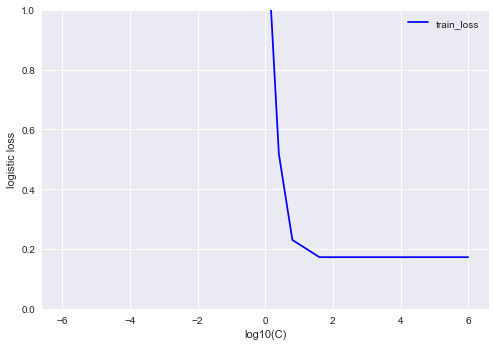

In [175]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 1]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Cross-Validation

In [176]:
Best_C_svm = C_grid[idx_min]
folds = StratifiedKFold(n_splits=10,random_state=1)

X = x_tr
y = np.array(y_tr)
k = 0
scores_svm = []
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVC(C=Best_C_svm,gamma='scale')
    clf.fit(x_train, y_tr)
    scores_svm.append(clf.score(X_test,y_test))
    print('Fold: %s, Acc: %.3f' % (k, clf.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Acc: 1.000
Fold: 2, Acc: 1.000
Fold: 3, Acc: 0.992
Fold: 4, Acc: 1.000
Fold: 5, Acc: 0.992
Fold: 6, Acc: 0.992
Fold: 7, Acc: 0.992
Fold: 8, Acc: 0.992
Fold: 9, Acc: 1.000
Fold: 10, Acc: 0.992

Cross-Validation accuracy: 0.995 +/- 0.004


### Check the Learning Curve

In [177]:
y = np.array(y_tr)
np.unique(y)

array([0, 1])

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


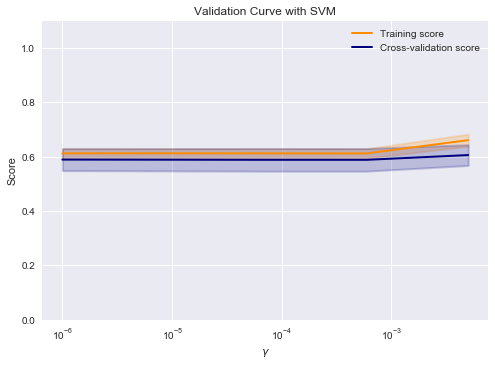

In [178]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
X = x_tr
y = np.array(y_tr)
#建立参数测试集
param_range = np.logspace(-6, -2.3, 5)

train_scores, test_scores = validation_curve(
    svm.SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better fo

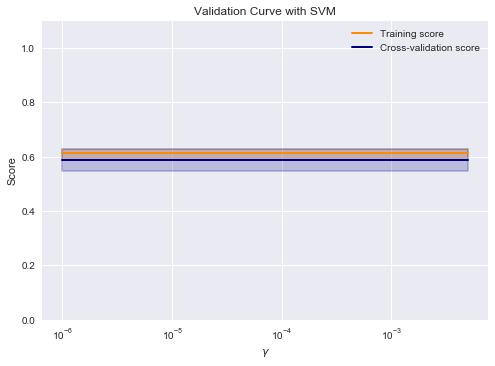

In [179]:
param_range = np.logspace(-6, -2.3, 5)

train_scores, test_scores = validation_curve(
    svm.SVC(), X, y, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [180]:
x_train = X_tf_train
tr_loss_list = []
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C

for c in C_grid:
    clf = svm.SVC(C=c,gamma='scale')
    clf.fit(x_train, y_tr)
    pred = clf.predict(x_train)
    
    tr_loss_list.append(log_loss(y_tr, pred))

idx_min = tr_loss_list.index(min(tr_loss_list))

Best C-value for LR : 6.310
Train set log-loss at best C-value: 0.0000


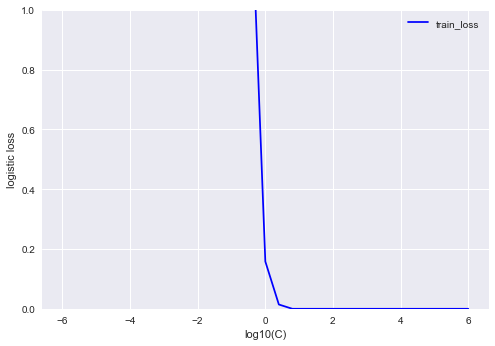

In [181]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 1]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Cross-Validation: K-Fold for TF-IDF
__choose the best hyperparameter and then predict the result__<br>in this validation, choose k=10

In [182]:
Best_C_svm_tf = C_grid[idx_min]
folds = StratifiedKFold(n_splits=10,random_state=1)

X =  X_tf_train
y = np.array(y_tr)
k = 0
scores_svm = []
for train_index, test_index in folds.split(X,y ):
    k +=1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVC(C=Best_C_svm_tf,gamma='scale')
    clf.fit(x_train, y_tr)
    scores_svm.append(clf.score(X_test,y_test))
    print('Fold: %s, Acc: %.3f' % (k, clf.score(X_test,y_test)))
    
print('\nCross-Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Acc: 1.000
Fold: 2, Acc: 1.000
Fold: 3, Acc: 1.000
Fold: 4, Acc: 1.000
Fold: 5, Acc: 1.000
Fold: 6, Acc: 1.000
Fold: 7, Acc: 1.000
Fold: 8, Acc: 1.000
Fold: 9, Acc: 1.000
Fold: 10, Acc: 1.000

Cross-Validation accuracy: 1.000 +/- 0.000


### Output the result of Prediction

In [228]:
import pandas as pd
X =  X_tf_train
y = np.array(y_tr)
clf = svm.SVC(C=Best_C_svm_tf,gamma='scale')
clf.fit(x_train, y_tr)
ypred_test = clf.predict(X_tf_test)
np.savetxt('yproba1_test.txt', ypred_test)

In [221]:
df = pd.DataFrame(ypred_test)
#df.columns=['is_positive_sentiment']
df.to_csv('y_test.csv', index=False,header=False)
ypred_test.shape

(600,)